# Imports

### Modules and libraries 

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib

from tqdm import tqdm
import sys
import os

import warnings
warnings.filterwarnings("ignore")

# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'


from collections import defaultdict


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc


import module.random_forest_impl as mymodule

### Data


In [2]:
X = pd.read_csv('data/x_spam_train.csv').drop('Id', axis=1)
y = pd.read_csv('data/y_spam_train.csv').drop('Id', axis=1)

y.rename({"Expected": 'y'}, inplace=True, axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

So, this task was tough but extremely exciting. Implementation forest and realizing your 1000-line code do things is insane. I really enjoyed the process!
All the functions are stored in `random_fores_impl.py`, code is pretty readable, there are although some comments, I guess they should help. Anyway, let's dive in!

### 1. Fit and predict methods for Random Forest Classifier
This part of the article is not that hard. Firstly, in the loop of `n_estimators` I fitted the tree with the given hyper-parameters,
then store all of them in special attribute forest for this classifier.
Fitting part is done! All we have to do is just making a prediction for test data for each tree and let them proceed major voting. Once they are done we have all our awesome predictions for each observation from test! <br>
Let's check the results.

**Simple random forest with default parameters I set in my module**

In [3]:
%%time
rf_simple = mymodule.RandomForestClassifier()

rf_simple.fit(X_train, y_train)

Tree number 0 is fitting on 2944 observations and features are from: ['13', '46', '1', '12']
---***---
10 trees to go! almost there
Tree number 1 is fitting on 2944 observations and features are from: ['47', '45', '30', '26']
---***---
9 trees to go! almost there
Tree number 2 is fitting on 2944 observations and features are from: ['3', '22', '10', '12']
---***---
8 trees to go! almost there
Tree number 3 is fitting on 2944 observations and features are from: ['56', '5', '11', '14']
---***---
7 trees to go! almost there
Tree number 4 is fitting on 2944 observations and features are from: ['27', '16', '6', '42']
---***---
6 trees to go! almost there
Tree number 5 is fitting on 2944 observations and features are from: ['14', '30', '44', '21']
---***---
5 trees to go! almost there
Tree number 6 is fitting on 2944 observations and features are from: ['14', '25', '55', '53']
---***---
4 trees to go! almost there
Tree number 7 is fitting on 2944 observations and features are from: ['39', '8'

Oh! It was pretty fast even though there are not that many trees in the forest. Let's validate and get results

In [4]:
rc_auc_score_simple_model = roc_auc_score(y_test['y'].values, np.array(rf_simple.predict(X_test)[1]))

print(f'Roc Auc Score for Simple Random Forest with default params is {rc_auc_score_simple_model:.4f}')

Roc Auc Score for Simple Random Forest with default params is 0.8804


Great performance even for simple forest! Wait for more.

### 2. Searching for optimal hyper-parameters

Now when we are sure that all is set right, and we are ready to go we can try to calibrate hyper-parameters to reach the best performance.
How we can do that? Let's assume we take `n_estimators` from set {5, 10, 20, 30, 50, 100} and `max_depth` from set {2, 3, 5, 7, 10}.
If we use naïve approach we can build 30 classifiers with every pair of these model parameters, but how long it will take to fit? I think it is straight brute-force, and we obviously recalculate splits over and over again.
Let's try more efficient approach: build classifier with 100 trees each with a maximum depth of 10. So on this step we have huge forest with somewhat tall trees.
We can randomly choose needed number of trees for remain values in first set (< 100), when we want less deep tree we can just cut nodes once maximum depth was reached. <br>

I implemented this in `module`. I slightly reorganized my `DecisionTreeClassifier` and added new method. Then integrated method for `RandomTreeClassifier` using that new method for trees.
- Method `predict_cut_tree` for `DecisionTreeClassifier` is essentially a method that has ability to build prediction, but stops when new depth is reached. We need that for cutting trees to make them shorter in new forest.
- Method `predict_less_trees_depth` randomly choose tree from forest and cut all remained nodes when maximum depth is reached. 
These two methods will be useful for that advanced strategy for finding optimal pair of hyper-parameters. Also, checkout my fancy appearance for output that model provides!

#### 2.1 Building 100 trees with maximum depth 100

Theory suggests picking $\sqrt{m}$ features for each tree, in our case m = 7. Number of trees is 100, maximum possible depth is 10.

In [5]:
%%time
k = int(np.sqrt(len(X_train.columns)))
rf_main = mymodule.RandomForestClassifier(max_depth=10, 
                               min_samples_leaf=25, 
                               max_features=k, 
                               n_estimators=100)


rf_main.fit(X_train, y_train)

Tree number 0 is fitting on 2944 observations and features are from: ['31', '4', '22', '46', '35', '17', '43']
---***---
100 trees to go! almost there
Tree number 1 is fitting on 2944 observations and features are from: ['8', '1', '41', '43', '54', '34', '47']
---***---
99 trees to go! almost there
Tree number 2 is fitting on 2944 observations and features are from: ['30', '13', '38', '21', '18', '47', '25']
---***---
98 trees to go! almost there
Tree number 3 is fitting on 2944 observations and features are from: ['2', '36', '45', '20', '42', '25', '23']
---***---
97 trees to go! almost there
Tree number 4 is fitting on 2944 observations and features are from: ['55', '39', '24', '18', '12', '27', '4']
---***---
96 trees to go! almost there
Tree number 5 is fitting on 2944 observations and features are from: ['22', '3', '21', '28', '17', '45', '56']
---***---
95 trees to go! almost there
Tree number 6 is fitting on 2944 observations and features are from: ['22', '46', '51', '4', '20', 

#### 2.2 Grid search 

At this point we can start to cut our tree. Function `grid_search` was built to find optimal params,
but it uses advanced strategy to get all scores from each classifier, and it works pretty fast! It returns sorted array with scores and related number of trees and maximum depth.

In [6]:
n_estimator_list = [5, 10, 20, 30, 50, 100]
max_depth_list = [2, 3, 5, 7, 10]

In [7]:
%%time

gs_results = mymodule.grid_search(n_estimator_list,
                     max_depth_list,
                     rf_main,
                     X_test, y_test)

********************-----_______-----********************
Cutting tree using parametrs: 5 estimators and 2 is a new depth
********************-----_______-----********************
I chose 21-th random tree
__________
736 is length of j-th tree preds
----------
I chose 11-th random tree
__________
736 is length of j-th tree preds
----------
I chose 8-th random tree
__________
736 is length of j-th tree preds
----------
I chose 30-th random tree
__________
736 is length of j-th tree preds
----------
I chose 68-th random tree
__________
736 is length of j-th tree preds
----------
********************-----_______-----********************
Cutting tree using parametrs: 5 estimators and 3 is a new depth
********************-----_______-----********************
I chose 33-th random tree
__________
736 is length of j-th tree preds
----------
I chose 96-th random tree
__________
736 is length of j-th tree preds
----------
I chose 19-th random tree
__________
736 is length of j-th tree preds
----

Looks like our gird search got results for each classifier in less than 20 seconds! Let's review these results.

In [8]:
for k in range(3):
    sc = gs_results[k]["scores"]
    n = gs_results[k]['n_est']
    md = gs_results[k]['max_d']
    print(f'{k+1}-best Random Forest has \n Roc Auc score = {sc:.3f} \n Number of trees = {n} \n Maximum depth = {md}')


1-best Random Forest has 
 Roc Auc score = 0.958 
 Number of trees = 50 
 Maximum depth = 7
2-best Random Forest has 
 Roc Auc score = 0.956 
 Number of trees = 30 
 Maximum depth = 7
3-best Random Forest has 
 Roc Auc score = 0.956 
 Number of trees = 100 
 Maximum depth = 10


Well, it is interesting to see, that RF with pair (50, 7) has almost the same score as RF with pair (100, 10).
It means that for some number of trees every new added tree to the forest has its improving less and less. In other words margin influence is lower.

###  3. Reviewing results for best classifier

Now it is time to draw some nice pictures! We are going to draw Roc-Curve using method defined in my module.

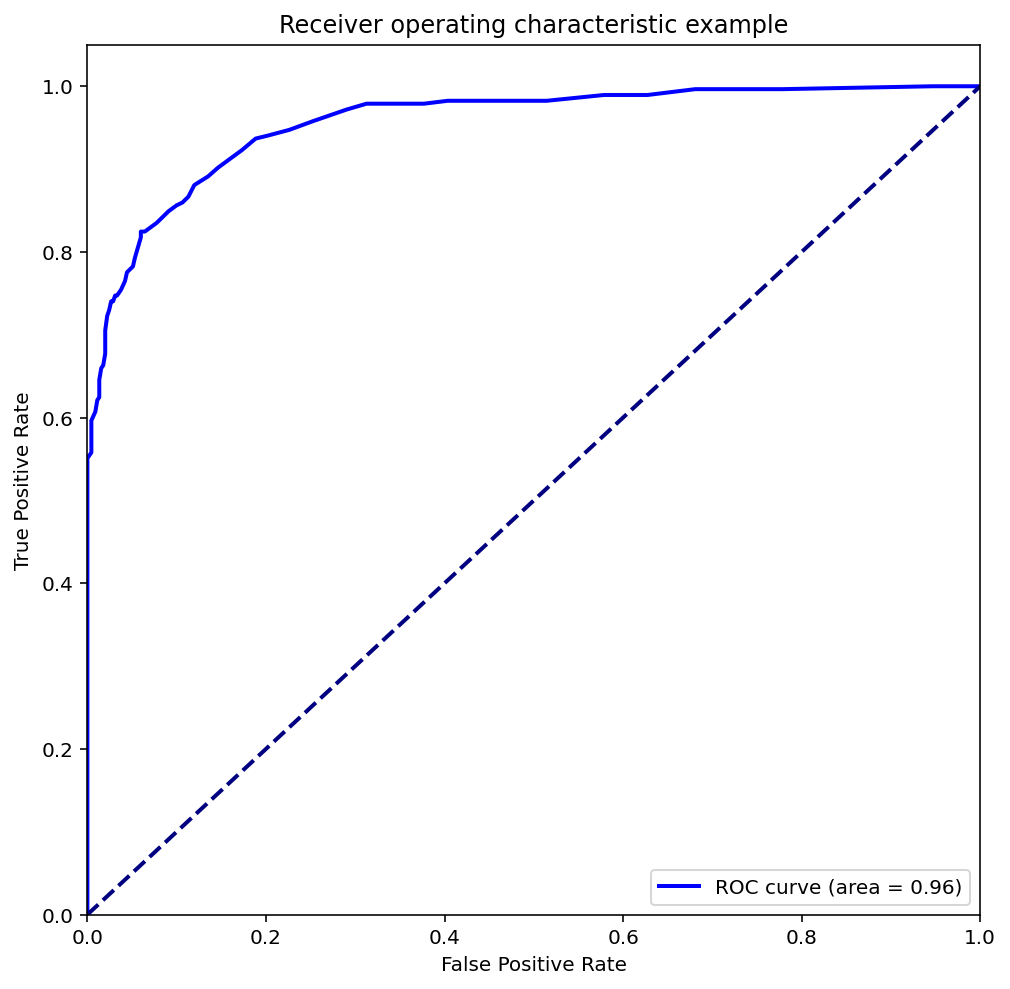

Your Rocking awesome AUC score is 0.9558252616018983
Your Rocking awesome Accuracy score is 0.8505434782608695


In [9]:
mymodule.print_roc_auc(y_test, rf_main.predict(X_test))

It is in fact fancy. So we are clearly see that our model build good predictions

_Note_. We have to validate through our best-performance forest using `Out-of-Bag errors` and see what are the most important features we have.
If you can see in my module I developed method `get_feature_importance` in my implementation of `Random Forest Classifier` and I am sure it works.
But since this method iterating for each observation and each tree that did not see it and do it over and over again, it takes a lot of time to deploy.
If you want to speed up calculations you can try some cloud services that provides GPU.

### 4. Testing other implementation of Boosting

#### 4.1 CatBoost

In [10]:
from catboost import CatBoostClassifier

In [11]:
%%time
cat = CatBoostClassifier()
cat.fit(X_train, y_train, logging_level='Silent')

CPU times: user 20.5 s, sys: 1.46 s, total: 22 s
Wall time: 6.33 s


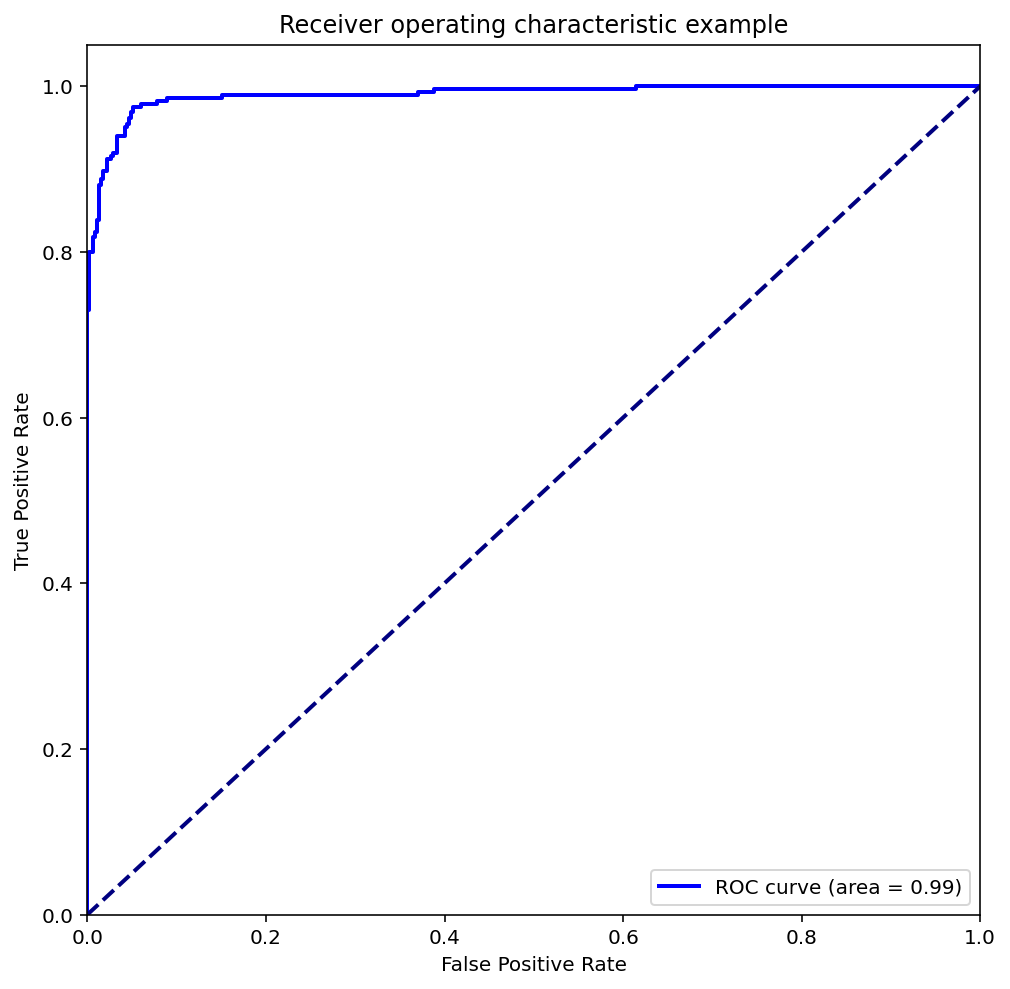

Your Rocking awesome AUC score is 0.9896837437273894
Your Rocking awesome Accuracy score is 0.9524456521739131


In [12]:
mymodule.print_roc_auc(y_test, 
                       (cat.predict(X_test), 
                        np.array([x[1] for x in cat.predict_proba(X_test)])))

#### 4.2 LightGBM

In [13]:
from lightgbm import LGBMClassifier


In [14]:
%%time
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)

CPU times: user 2.38 s, sys: 34 ms, total: 2.42 s
Wall time: 739 ms


LGBMClassifier()

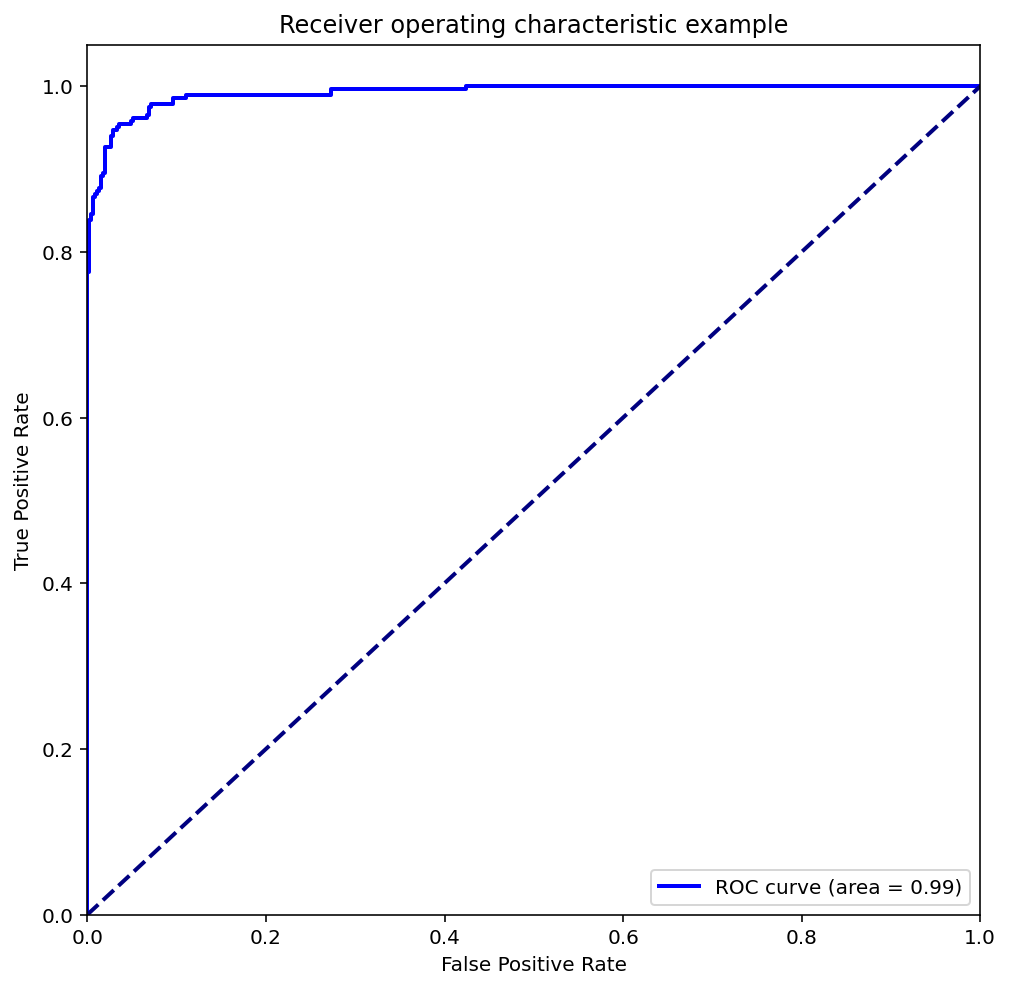

Your Rocking awesome AUC score is 0.9918310187886568
Your Rocking awesome Accuracy score is 0.9524456521739131


In [15]:
mymodule.print_roc_auc(y_test, 
                       (cat.predict(X_test), 
                        np.array([x[1] for x in lgbm.predict_proba(X_test)])))

#### 4.3 XGBoost

In [16]:
from xgboost import XGBClassifier

In [17]:
%%time
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

[21:44:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 2.13 s, sys: 5.85 ms, total: 2.13 s
Wall time: 567 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

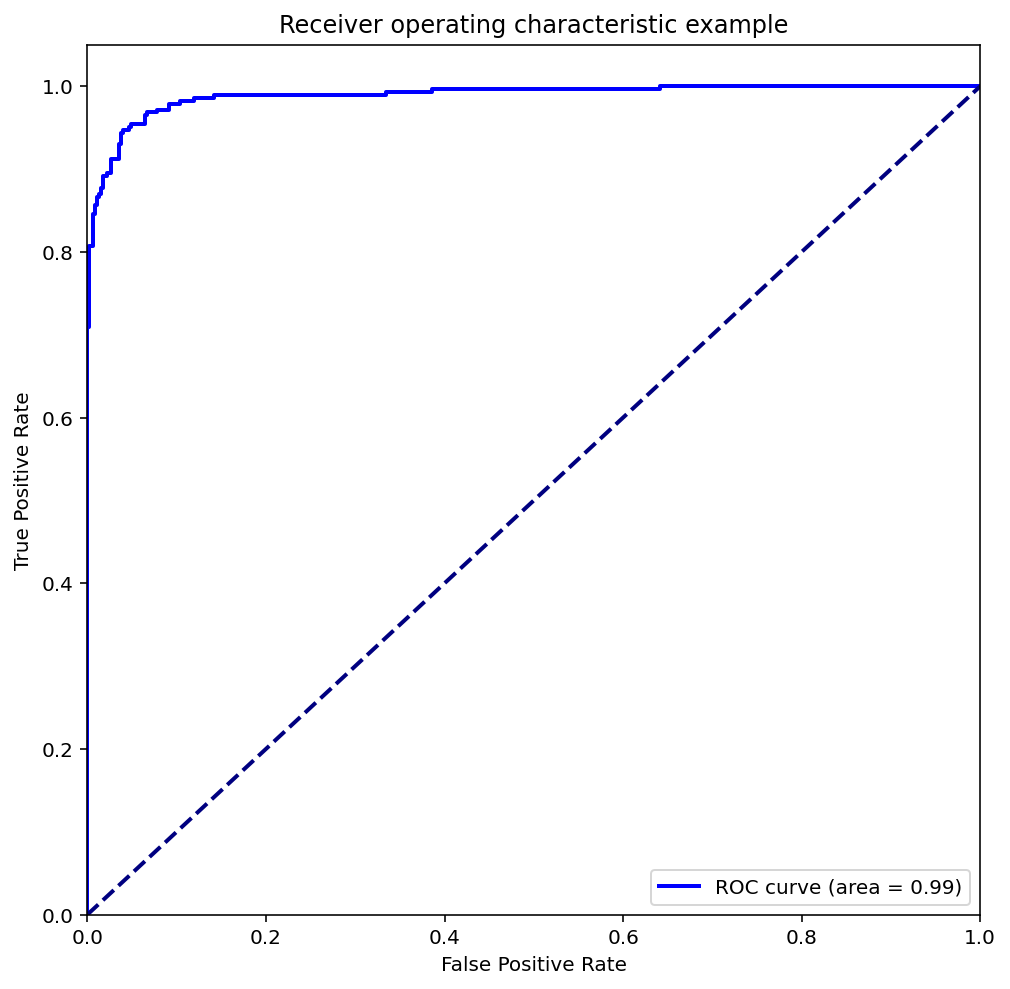

Your Rocking awesome AUC score is 0.988859065624149
Your Rocking awesome Accuracy score is 0.9524456521739131


In [18]:
mymodule.print_roc_auc(y_test, 
                       (cat.predict(X_test), 
                        np.array([x[1] for x in xgb.predict_proba(X_test)])))

### 5. Comparing results

From what we see on these graphs we can claim that all boosting performed in almost similar way, but I still can highlight some differences. <br>

- Firstly, we can see that CatBoost was the slowest one and LightGBM is the fastest one. But do not forget my classifier has learned for 11 minutes, 3 seconds is not that bad result. Even if we take into consideration the Kaggle server latency it is still the winner. As far as I know LightGBM is the oldest library, so they might use simple optimisation without storing or memoization data, it has fewer features and capabilities than CatBoost has.
- If we look closely on the Roc-curve we can see that my classifier has smooth curve, while other implementation has improvements from the beginning and then slightly reach upper axis.
- Also, I should mention that CatBoost has 500 estimators by default, while XGB and LightGBM has only 100 (mine too!)